In [21]:
# Install required packages
!pip install kaggle pandas-profiling plotly

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [24]:
# Setup Kaggle API (you'll need to upload your kaggle.json file first)
import os
from google.colab import files
# Upload kaggle.json file
uploaded = files.upload()
# Create kaggle directory and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download Heart Disease UCI dataset (assuming it's available as a dataset)
!kaggle datasets download -d ronitf/heart-disease-uci
# Unzip the files
!unzip heart-disease-uci.zip


Saving heart.csv to heart (2).csv
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open heart-disease-uci.zip, heart-disease-uci.zip.zip or heart-disease-uci.zip.ZIP.


In [25]:
# Load the dataset
df = pd.read_csv('heart.csv')  # Assuming the file is named this

print("Dataset shape:", df.shape)
print("First few rows:")
df.head()

Dataset shape: (303, 14)
First few rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [26]:
# Basic information about the dataset
print("Dataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDataset Description:")
df.describe()

# Handle missing values (Heart Disease UCI has few, but fill if any)
df.fillna(df.median(numeric_only=True), inplace=True)  # For numerical columns

# The target is 'target' (0: no disease, 1: disease present), which is already binary

print("After preprocessing:")
print("Dataset shape:", df.shape)
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


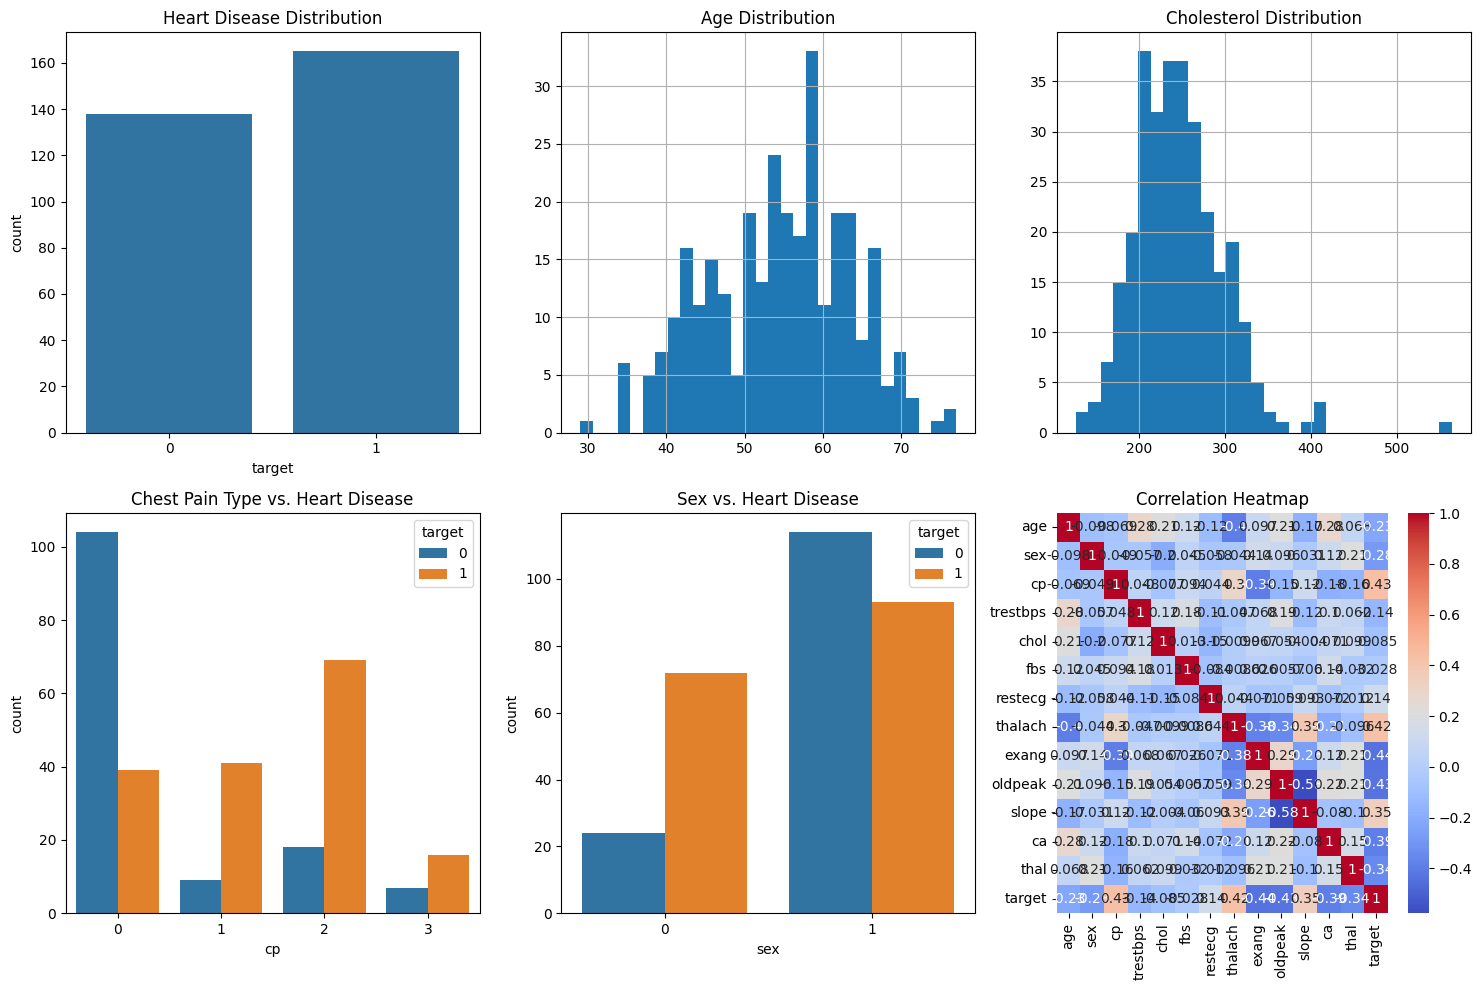

In [27]:
# Visualize the data
plt.figure(figsize=(15, 10))

# Subplot 1: Target distribution
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='target')
plt.title('Heart Disease Distribution')

# Subplot 2: Age distribution
plt.subplot(2, 3, 2)
df['age'].hist(bins=30)
plt.title('Age Distribution')

# Subplot 3: Cholesterol distribution
plt.subplot(2, 3, 3)
df['chol'].hist(bins=30)
plt.title('Cholesterol Distribution')

# Subplot 4: Chest pain type vs. target
plt.subplot(2, 3, 4)
sns.countplot(data=df, x='cp', hue='target')
plt.title('Chest Pain Type vs. Heart Disease')

# Subplot 5: Sex vs. target
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='sex', hue='target')
plt.title('Sex vs. Heart Disease')

# Subplot 6: Correlation heatmap
plt.subplot(2, 3, 6)
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [28]:
# Feature engineering
df_processed = df.copy()

# Encode categorical variables (e.g., cp, thal, slope are already numerical, but ensure)
# If needed, use LabelEncoder for any strings, but Heart Disease UCI is mostly numerical

# Create new features
df_processed['age_group'] = pd.cut(df_processed['age'], bins=[0, 40, 60, 100], labels=['young', 'middle', 'old'])
df_processed['chol_level'] = pd.cut(df_processed['chol'], bins=[0, 200, 240, 600], labels=['normal', 'borderline', 'high'])

# Encode new categorical features
label_encoder = LabelEncoder()
df_processed['age_group'] = label_encoder.fit_transform(df_processed['age_group'])
df_processed['chol_level'] = label_encoder.fit_transform(df_processed['chol_level'])

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

print("Processed dataset shape:", df_processed.shape)
df_processed.head()

Processed dataset shape: (303, 16)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,chol_level
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,1.087338,0,0,1,1,1,0
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,2.122573,0,0,2,1,2,1
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,0.310912,2,0,2,1,0,0
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,-0.206705,2,0,2,1,0,0
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,-0.379244,2,0,2,1,0,1


In [29]:
# Split features and target
X = df_processed.drop('target', axis=1)
y = df_processed['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Initialize models (focusing on Random Forest, with others for comparison)
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train models, perform cross-validation, and store results
results = {}
cv_results = {}
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = {
        'mean_cv_accuracy': cv_scores.mean(),
        'std_cv_accuracy': cv_scores.std(),
        'cv_scores': cv_scores
    }

    # Train on full training set for validation predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred
    }
    print(f"{name}: CV Mean Accuracy={cv_scores.mean():.4f} (±{cv_scores.std():.4f}), Val Accuracy={accuracy:.4f}, AUC={auc:.4f}")

# Hyperparameter tuning for Random Forest using GridSearchCV
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_
best_rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='accuracy')
y_pred_best_rf = best_rf.predict(X_val)
best_rf_accuracy = accuracy_score(y_val, y_pred_best_rf)
best_rf_auc = roc_auc_score(y_val, y_pred_best_rf)

print(f"\nTuned Random Forest: Best Params={rf_grid_search.best_params_}")
print(f"Tuned RF CV Mean Accuracy={best_rf_cv_scores.mean():.4f} (±{best_rf_cv_scores.std():.4f}), Val Accuracy={best_rf_accuracy:.4f}, AUC={best_rf_auc:.4f}")

# Update results with tuned RF
results['Tuned Random Forest'] = {
    'model': best_rf,
    'accuracy': best_rf_accuracy,
    'auc': best_rf_auc,
    'predictions': y_pred_best_rf
}
cv_results['Tuned Random Forest'] = {
    'mean_cv_accuracy': best_rf_cv_scores.mean(),
    'std_cv_accuracy': best_rf_cv_scores.std(),
    'cv_scores': best_rf_cv_scores
}

Training set: (242, 15)
Validation set: (61, 15)
Random Forest: CV Mean Accuracy=0.8056 (±0.0787), Val Accuracy=0.8197, AUC=0.8090
Logistic Regression: CV Mean Accuracy=0.8137 (±0.0878), Val Accuracy=0.8033, AUC=0.7938
Decision Tree: CV Mean Accuracy=0.7478 (±0.0872), Val Accuracy=0.6557, AUC=0.6439
SVM: CV Mean Accuracy=0.8264 (±0.0366), Val Accuracy=0.8033, AUC=0.7911
K-Nearest Neighbors: CV Mean Accuracy=0.7850 (±0.0523), Val Accuracy=0.8033, AUC=0.7938
Gradient Boosting: CV Mean Accuracy=0.7605 (±0.0985), Val Accuracy=0.8197, AUC=0.8144
XGBoost: CV Mean Accuracy=0.8019 (±0.0821), Val Accuracy=0.8033, AUC=0.7938

Tuned Random Forest: Best Params={'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Tuned RF CV Mean Accuracy=0.8180 (±0.0877), Val Accuracy=0.7869, AUC=0.7760


Model Performance Comparison:
                 Model  Accuracy       AUC
0        Random Forest  0.819672  0.808983
5    Gradient Boosting  0.819672  0.814394
3                  SVM  0.803279  0.791126
1  Logistic Regression  0.803279  0.793831
6              XGBoost  0.803279  0.793831
4  K-Nearest Neighbors  0.803279  0.793831
7  Tuned Random Forest  0.786885  0.775974
2        Decision Tree  0.655738  0.643939


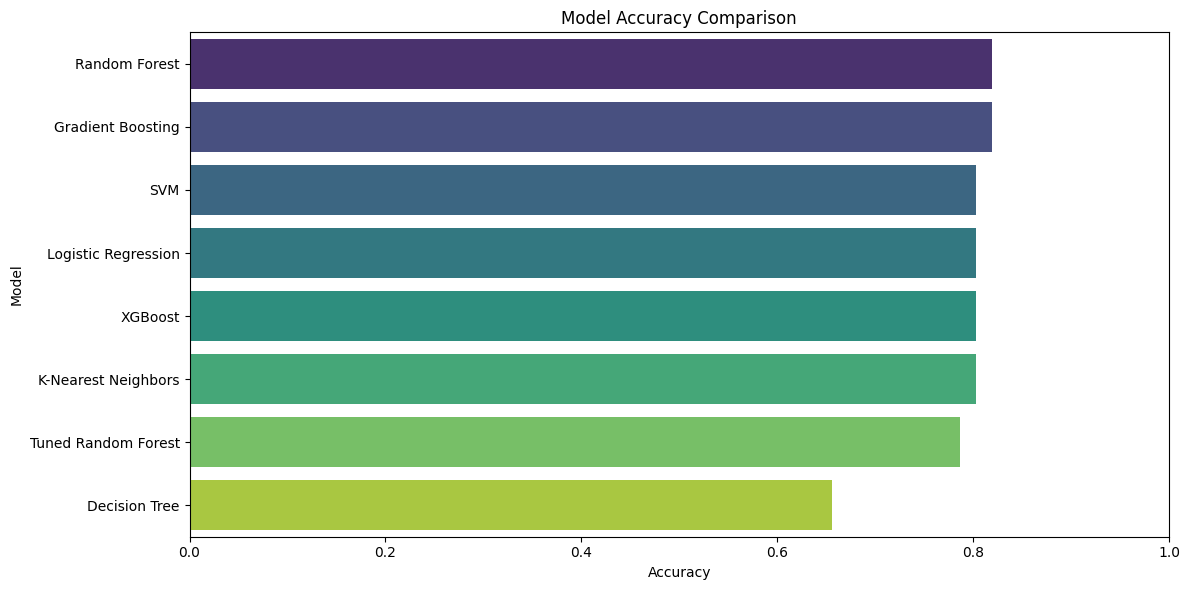


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78        28
           1       0.78      0.94      0.85        33

    accuracy                           0.82        61
   macro avg       0.84      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



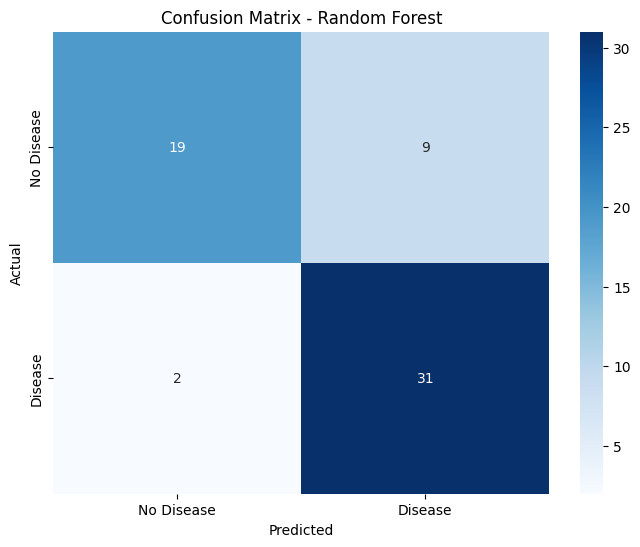

In [30]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'AUC': [results[model]['auc'] for model in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("Model Performance Comparison:")
print(comparison_df)

# Visualize model comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

# Detailed evaluation for Random Forest
model_name = 'Random Forest'
print(f"\n{model_name} Classification Report:")
print(classification_report(y_val, results[model_name]['predictions']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, results[model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
print("="*50)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*50)

for i, (model, accuracy, auc) in enumerate(zip(comparison_df['Model'], comparison_df['Accuracy'], comparison_df['AUC']), 1):
    print(f"{i}. {model}: Accuracy={accuracy:.4f}, AUC={auc:.4f}")

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"📊 Validation Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"🔄 AUC: {results[best_model_name]['auc']:.4f}")

# Additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_val, results[best_model_name]['predictions'])
recall = recall_score(y_val, results[best_model_name]['predictions'])
f1 = f1_score(y_val, results[best_model_name]['predictions'])

print(f"🎯 Precision: {precision:.4f}")
print(f"🔍 Recall: {recall:.4f}")
print(f"⭐ F1-Score: {f1:.4f}")

print("\nDiscussion:")
print("- Random Forest handles non-linear features well, often outperforming simpler models due to ensemble averaging.")
print("- Limitations: Small dataset size may lead to overfitting; consider larger datasets or cross-validation.")
print("- Improvements: Hyperparameter tuning (e.g., n_estimators), feature selection, or trying neural networks.")

FINAL MODEL COMPARISON SUMMARY
1. Random Forest: Accuracy=0.8197, AUC=0.8090
2. Gradient Boosting: Accuracy=0.8197, AUC=0.8144
3. SVM: Accuracy=0.8033, AUC=0.7911
4. Logistic Regression: Accuracy=0.8033, AUC=0.7938
5. XGBoost: Accuracy=0.8033, AUC=0.7938
6. K-Nearest Neighbors: Accuracy=0.8033, AUC=0.7938
7. Tuned Random Forest: Accuracy=0.7869, AUC=0.7760
8. Decision Tree: Accuracy=0.6557, AUC=0.6439

🏆 BEST MODEL: Random Forest
📊 Validation Accuracy: 0.8197
🔄 AUC: 0.8090
🎯 Precision: 0.7750
🔍 Recall: 0.9394
⭐ F1-Score: 0.8493

Discussion:
- Random Forest handles non-linear features well, often outperforming simpler models due to ensemble averaging.
- Limitations: Small dataset size may lead to overfitting; consider larger datasets or cross-validation.
- Improvements: Hyperparameter tuning (e.g., n_estimators), feature selection, or trying neural networks.
